# Importing Libraries

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#Analyzing Dataset

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df.head(20)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


📌 dataset is balanced (equal positive and negative sentiments)

In [5]:
df['review'][10]

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

In [6]:
df['review'][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

#Cleaning and Preprocessing

In [7]:
df['review'] = df['review'].astype(str)
df['sentiment'] = df['sentiment'].replace({"negative":0, "positive":1}).astype(int)
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in STOPWORDS]

    text = ' '.join(tokens)
    return text
df['review'] = df['review'].apply(clean_text)


/tmp/ipython-input-970751746.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({"negative":0, "positive":1}).astype(int)


#Word Representation

In [8]:
vectroizer = TfidfVectorizer()
reviews = vectroizer.fit_transform(df['review'])

print(reviews)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4987048 stored elements and shape (50000, 176188)>
  Coords	Values
  (0, 109939)	0.017864438247802122
  (0, 129493)	0.06357205993256244
  (0, 96875)	0.05551794974667286
  (0, 169047)	0.06512615710806402
  (0, 112730)	0.37499122367707366
  (0, 49033)	0.09655962552762057
  (0, 175017)	0.045859313109771704
  (0, 72179)	0.07016365673032528
  (0, 130140)	0.07298521882365948
  (0, 50506)	0.048532054065711434
  (0, 67660)	0.04862577158906166
  (0, 96042)	0.06440980392077092
  (0, 18530)	0.05180945246810875
  (0, 55708)	0.05386068435987689
  (0, 155883)	0.03278898320625717
  (0, 149310)	0.14058499318265388
  (0, 20023)	0.0783390298517777
  (0, 163439)	0.09381961289526429
  (0, 134794)	0.03223470631252641
  (0, 167182)	0.19890268489031054
  (0, 138168)	0.040001559661703684
  (0, 172907)	0.049781164445027185
  (0, 62916)	0.03191282992493006
  (0, 160724)	0.06157607388573895
  (0, 140206)	0.10246064033645466
  :	:
  (49999, 87291)	0.09

#Logistic Regression

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews,df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)

clf = LogisticRegression(max_iter=200, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


print(classification_report(y_test, y_pred))

Accuracy: 0.8947
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      5000
           1       0.89      0.90      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



#Bonus ⭐

##Visualizing most frequent positive and negative words

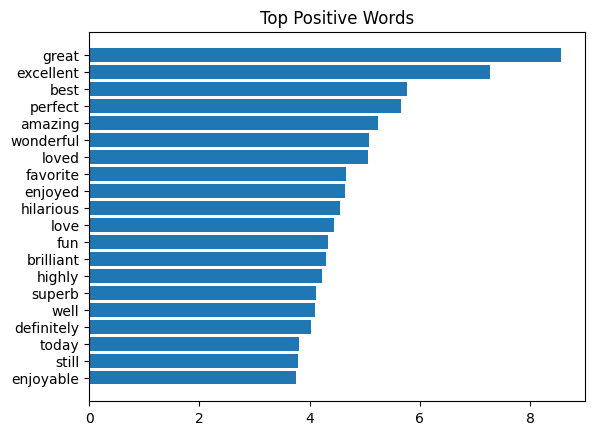

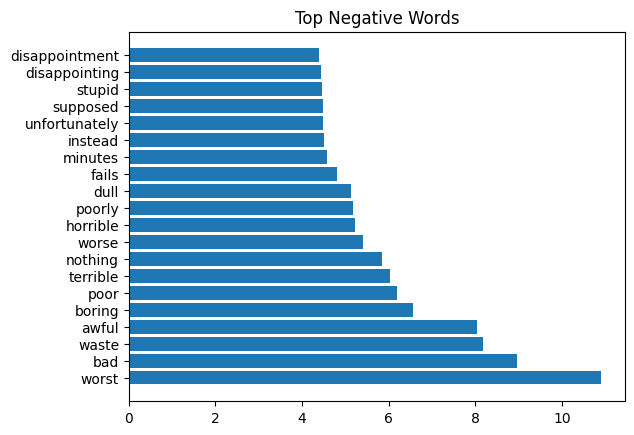

In [10]:
import matplotlib.pyplot as plt
vocab = np.array(vectroizer.get_feature_names_out())
coefs = clf.coef_.ravel()

top_pos = np.argsort(coefs)[-20:]
top_neg = np.argsort(coefs)[:20]

plt.barh(vocab[top_pos], coefs[top_pos])
plt.title("Top Positive Words")
plt.show()

plt.barh(vocab[top_neg], np.abs(coefs[top_neg]))
plt.title("Top Negative Words")
plt.show()


##Naive Bayes Classification

In [11]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.866
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5000
           1       0.88      0.85      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Logistic Regression performed better than Naive Bayes on IMDB sentiment analysis, achieving 0.89 accuracy compared to 0.86. While both models generalize well, LR’s discriminative nature and better handling of TF-IDF features make it superior in this case.